# Assignement E06 - DSIM 
*Marco Donzella 829358*

Implement a classification script based on the fine tuning of a neural network, following the guidelines shown during the laboratory.

Rules:

1. Use the same 101-object dataset
2. Use a different architecture (i.e. no mobile net)
3. Experiment with Data augmentation operations

Submission:

1. Notebook with well-commented steps and observations on the results.
2. If you submit a .py script instead of a notebook, attach a short report for the observations on the results.
3. Name the submitted file as: E06_surname_name_studentID

## Data loader

In [ ]:
from tensorflow import keras
import tarfile
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Si effettua il collegamento a google drive ed il successivo caricamento dei dati utili all'analisi. 

Per l'analisi, i dati usati sono stati estratti dal file *101_ObjectCategories_split.tar*; per un'esecuzione più veloce del codice si consiglia di usare il file *101_ObjectCategories_smallersplit.tar*, ovvero la versione ridotta del dataset originale.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/MyDrive/Digital Signal and Image Management/lezione 6/101_ObjectCategories_split.tar', '101_ObjectCategories_split.tar')
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()

In seguito definiamo i dataset di training e test:

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    '101_ObjectCategories_split/train',
    image_size = (224,224),
    color_mode = 'rgb',
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True,
    seed = 1
)

Found 4600 files belonging to 102 classes.


In [ ]:
test_dataset = keras.preprocessing.image_dataset_from_directory(
    '101_ObjectCategories_split/test',
    image_size = (224,224),
    color_mode = 'rgb',
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True,
    seed = 1
)

Found 4544 files belonging to 102 classes.


## Loading the base model

Ora istanziamo la rete *Xception* per risolvere il problema di classificazione.
Tale rete è stata scelta per via del buon compromesso tra numero di parametri stimati ed accuracy. Di seguito un link con le principali caratteristiche della rete: https://keras.io/api/applications/xception/.

In [ ]:
base_net = keras.applications.Xception(
    include_top=False,
    weights="imagenet", # pre-trained model
    input_shape=(224,224,3),
    pooling='avg')

83697664/83683744 [==============================] - 1s 0us/step


Di seguito viene visualizzata la struttura della rete (graficamente):

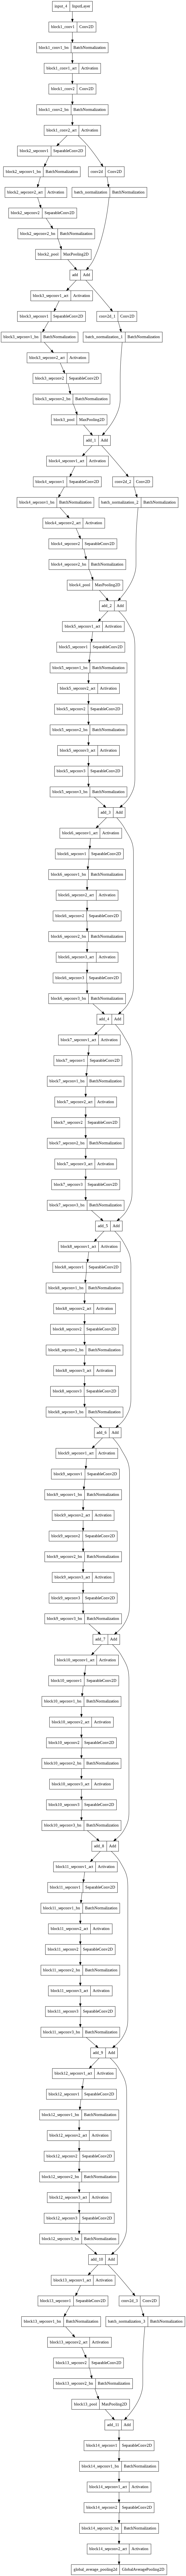

In [ ]:
keras.utils.plot_model(base_net)

## Data augmentation & Model specialization

Si decide di mantenere inalterati i pesi dei layers che provengono dal modello pre-addestrato, così da fare finetuning.

In [ ]:
for layer in base_net.layers:
  layer.trainable = False 

Viene specializzato il modello, arricchendolo con fasi di data augmentation, volte ad elevare la numerosità di informazioni carpibili dai dati. Viene così definito il metodo di lavoro della rete in questo specifico caso di studio.

Per avere migliori performance del modello, senza dover richiedere un aumento del numero dei dati di training a disposizione, è stata aggiunta una fase di data augmentation al modello, in cui vengono definite le seguenti modalità di elaborazione dei dati in input:
- *RandomFlip*, che consiste nel capovolgere l'immagine;
- *RandomRotation*, che consiste nel rotare l'immagine con un'inclinazione a scelta (in questo caso 20% * 2pi).

Successivamente si è proseguito con la costruzione del modello vero e proprio.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3)) # explicit input layer
data_augmentation = keras.Sequential([
                                      keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      #keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                                      keras.layers.experimental.preprocessing.RandomRotation(0.1)
                                      #keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3))
])
x = data_augmentation(inputs)
# Image preprocessing for consistency with the pretrained model
x = keras.applications.xception.preprocess_input(x)
# Output of the base model
x = base_net(x)
# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
outputs = keras.layers.Dense(102, activation='softmax')(x)

In [ ]:
net = keras.Model(inputs=inputs, outputs=outputs)

Vengono riportate le caratteristiche della rete specializzata appena creata:

In [ ]:
net.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 1024)              2098

Si prosegue ora con la compilazione della rete ed il relativo addestramento:

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(), # RMSprop() per l'ottimizzazione
            metrics=['accuracy'])

In [ ]:
net.fit(train_dataset,
          epochs=2, # scegliere il numero di epoche
          validation_data=test_dataset);

Epoch 1/2
144/144 [==============================] - 1750s 12s/step - loss: 1.3825 - accuracy: 0.6817 - val_loss: 0.7096 - val_accuracy: 0.8187
Epoch 2/2
144/144 [==============================] - 1707s 12s/step - loss: 0.4928 - accuracy: 0.8587 - val_loss: 0.4530 - val_accuracy: 0.8770


Si valuta ora la rete sul test set:

In [ ]:
net.evaluate(test_dataset)

142/142 [==============================] - 821s 6s/step - loss: 0.4530 - accuracy: 0.8770


[0.4529867172241211, 0.8769806623458862]

La rete è caratterizzata da un elevato livello di accuracy, pari a 0.877.

Inserendo altre fasi di data augmentation, le performance del modello potrbbero migliorare. Bisogna però fare attenzione anche ai tempi computazionali, che di conseguenza verrebbero dilatati.

## Save model

Volendo il modello potrebbe essere salvato ed essere utilizzato per eventuali casi studio futuri:

In [ ]:
# net.save('mymodel_101.h5')